# Fraud Detection in Insurance — End-to-End Notebook


**Goal:** Implement a complete ML workflow for fraud detection using `insurance_claims.csv`.

**Checklist**
- [x] Load data
- [x] Inspect schema, dtypes, summary stats
- [x] Clean & preprocess (missing, outliers in `umbrella_limit`, encode, scale)
- [x] EDA (distributions, correlations, target split)
- [x] Feature selection (RFECV)
- [x] Train/Test split + SMOTE
- [x] Train models: SVM, RandomForest, VotingClassifier
- [x] Evaluate: precision, recall, F1, ROC-AUC, confusion matrix
- [x] Hyperparameter tuning (GridSearchCV example)
- [x] Interpret best model (SHAP)
- [x] Save best model for deployment


In [1]:
import os, sys, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support
)
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import joblib




## 1) Data loading

In [2]:

# Adjust the path if necessary
path = os.path.join('..', 'data', 'insurance_claims.csv')

if not os.path.exists(path):
    alt = os.path.join('data', 'insurance_claims.csv')
    if os.path.exists(alt):
        path = alt

df = pd.read_csv(path)

display(df.shape)
display(df.head())
display(df.info())
display(df.describe(include='all').transpose().head(10))


(1000, 40)

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
months_as_customer,1000.0,NaN,NaN,NaN,203.954,115.113174,0.0,115.75,199.5,276.25,479.0
age,1000.0,NaN,NaN,NaN,38.948,9.140287,19.0,32.0,38.0,44.0,64.0
policy_number,1000.0,NaN,NaN,NaN,546238.648,257063.005276,100804.0,335980.25,533135.0,759099.75,999435.0
policy_bind_date,1000,951,2006-01-01,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
policy_state,1000,3,OH,352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
policy_csl,1000,3,250/500,351,NaN,NaN,NaN,NaN,NaN,NaN,NaN
policy_deductable,1000.0,NaN,NaN,NaN,1136.0,611.864673,500.0,500.0,1000.0,2000.0,2000.0
policy_annual_premium,1000.0,NaN,NaN,NaN,1256.40615,244.167395,433.33,1089.6075,1257.2,1415.695,2047.59
umbrella_limit,1000.0,NaN,NaN,NaN,1101000.0,2297406.598118,-1000000.0,0.0,0.0,0.0,10000000.0
insured_zip,1000.0,NaN,NaN,NaN,501214.488,71701.610941,430104.0,448404.5,466445.5,603251.0,620962.0


In [3]:
df["insured_hobbies"].unique()

array(['sleeping', 'reading', 'board-games', 'bungie-jumping',
       'base-jumping', 'golf', 'camping', 'dancing', 'skydiving',
       'movies', 'hiking', 'yachting', 'paintball', 'chess', 'kayaking',
       'polo', 'basketball', 'video-games', 'cross-fit', 'exercise'],
      dtype=object)

## 2)  Cleaning & Type Fixes

In [4]:
df.columns = [c.strip().lower().replace(' ', '_').replace('-', '_') for c in df.columns]

# normalization to binary
if 'fraud_reported' in df.columns:
    # y/n — map to 1/0
    df['fraud_reported'] = df['fraud_reported'].map({'Y':1, 'N':0, 'y':1, 'n':0}).astype(int)

# missing summary
missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(20))


_c39                           1.000
authorities_contacted          0.091
fraud_reported                 0.000
auto_year                      0.000
incident_state                 0.000
incident_city                  0.000
incident_location              0.000
incident_hour_of_the_day       0.000
number_of_vehicles_involved    0.000
property_damage                0.000
bodily_injuries                0.000
witnesses                      0.000
age                            0.000
total_claim_amount             0.000
injury_claim                   0.000
property_claim                 0.000
vehicle_claim                  0.000
auto_make                      0.000
auto_model                     0.000
police_report_available        0.000
dtype: float64

### 2.1) Missing Value Handling

In [5]:
# idea: for numerics, impute mediam | for categoricals, most frequent
# implement imputation inside the pipeline, optionally drop extreme sparsity cols
sparsity_threshold = 0.6
to_drop = [c for c, m in missing.items() if m > sparsity_threshold]
print("Dropping:", to_drop)
df = df.drop(columns=to_drop, errors='ignore')


Dropping: ['_c39']


### 2.2) Outliers — `umbrella_limit`

In [6]:
# if limit exists, cap at a high percentile (winsorization-like)
if 'umbrella_limit' in df.columns:
    high = df['umbrella_limit'].quantile(0.99)
    low = df['umbrella_limit'].quantile(0.01)
    df['umbrella_limit'] = df['umbrella_limit'].clip(lower=low, upper=high)
    print("Capped umbrella_limit at 1st/99th percentiles:", low, high)


Capped umbrella_limit at 1st/99th percentiles: 0.0 8000000.0


## 3) EDA

Class distribution:
 fraud_reported
0    753
1    247
Name: count, dtype: int64
Numeric cols: 19
Categorical cols: 20


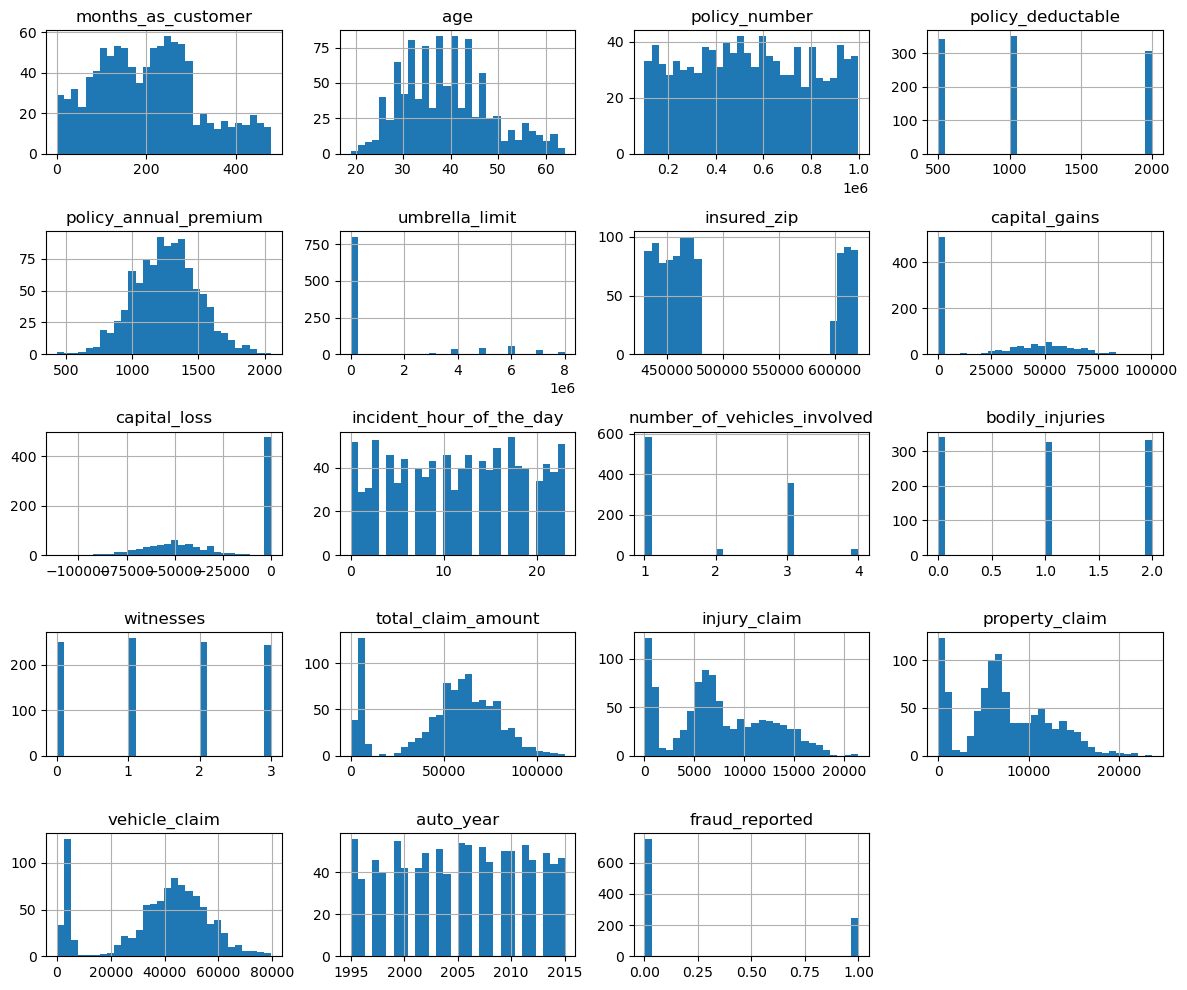

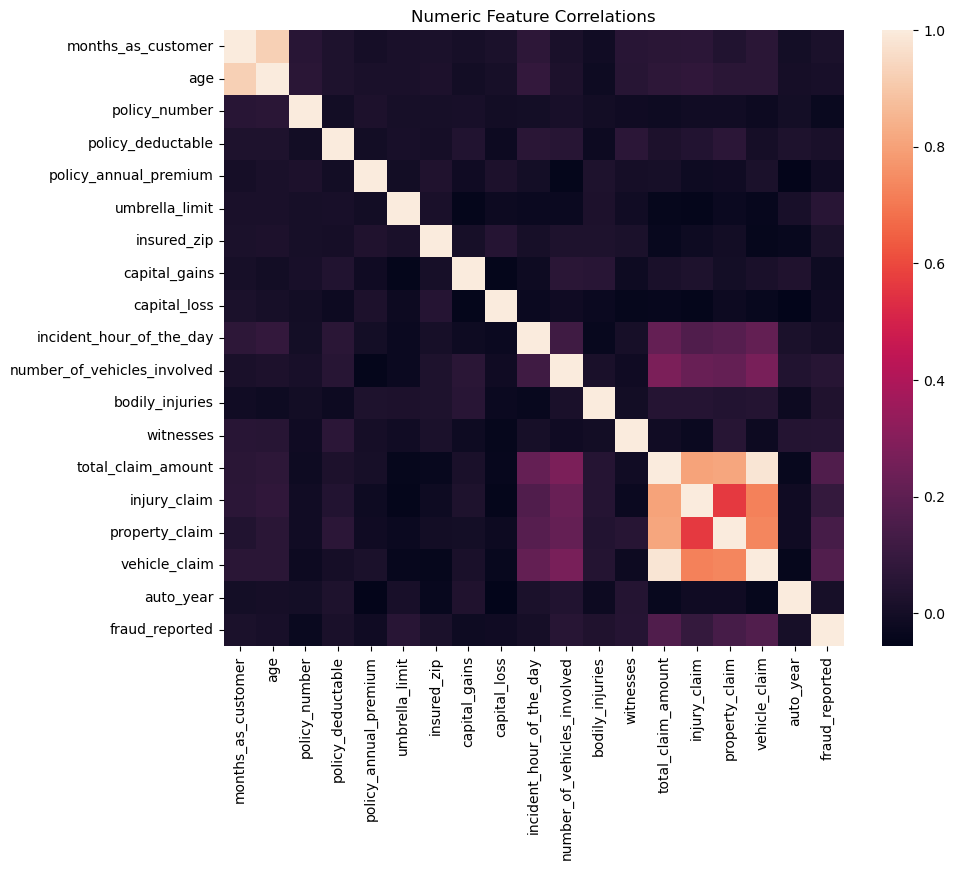

In [7]:
# target 
if 'fraud_reported' in df.columns:
    target_counts = df['fraud_reported'].value_counts(normalize=False)
    print("Class distribution:\n", target_counts)

# numeric/categorical split
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols and c != 'fraud_reported']

print("Numeric cols:", len(numeric_cols))
print("Categorical cols:", len(categorical_cols))

# Example plots (comment out if running headless)
_ = df[numeric_cols].hist(bins=30, figsize=(12, 10))
plt.tight_layout()
plt.show()

# heatmap for numerics
if len(numeric_cols) > 1:
    plt.figure(figsize=(10,8))
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=False)
    plt.title("Numeric Feature Correlations")
    plt.show()


## 4) Train Test Split

In [8]:
target = 'fraud_reported'
X = df.drop(columns=[target])
y = df[target]

import numpy as np
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# sanity check
candidate_cols = numeric_cols + categorical_cols
assert target not in candidate_cols

# small data: 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify=y,random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (800, 38) Test shape: (200, 38)


## 5) Preprocessing & RFECV Feature Selection

In [9]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', r(handle_unknown='ignore', sparse_output = False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
    ],
    remainder='drop',
    sparse_threshold=0.0         # force dense concat for shap

)

# using a baseline estimator for RFE cross val
estimator = LogisticRegression(max_iter=1000, n_jobs=None)
rfecv_model = Pipeline(steps=[
    ('prep', preprocessor),
    ('rfecv', RFECV(
        estimator=estimator,
        step=1,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='f1',
        n_jobs=-1
    ))
])

# RFECV expects numeric arrays post-transform; it will run within the pipeline
rfecv_model.fit(X_train, y_train)
print("RFECV selected features (support_ not directly available due to transformer). Proceeding with full feature set in final models while noting RFECV score.")


RFECV selected features (support_ not directly available due to transformer). Proceeding with full feature set in final models while noting RFECV score.


## 6) Modeling with SMOTE

In [10]:
# Define final preprocessing for models
final_preprocessor = preprocessor

# Base models
svc_clf = SVC(probability=True, kernel='rbf', class_weight='balanced', random_state=42)
rf_clf = RandomForestClassifier(
    n_estimators=300, max_depth=None, min_samples_split=2, min_samples_leaf=1,
    random_state=42, n_jobs=-1
)
log_clf = LogisticRegression(max_iter=2000)

# Imbalanced-learn pipeline with SMOTE
def make_pipeline(estimator):
    return ImbPipeline(steps=[
        ('prep', final_preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', estimator)
    ])

models = {
    'SVC': make_pipeline(svc_clf),
    'RandomForest': make_pipeline(rf_clf),
    'LogReg': make_pipeline(log_clf)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:,1]
    preds = (proba >= 0.5).astype(int)
    auc = roc_auc_score(y_test, proba)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary', zero_division=0)
    cm = confusion_matrix(y_test, preds)
    results[name] = {'auc': auc, 'precision': prec, 'recall': rec, 'f1': f1, 'cm': cm}
    print(f"\n=== {name} ===")
    print(f"AUC: {auc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}")
    print("Confusion Matrix:\n", cm)



=== SVC ===
AUC: 0.852  Precision: 0.605  Recall: 0.469  F1: 0.529
Confusion Matrix:
 [[136  15]
 [ 26  23]]

=== RandomForest ===
AUC: 0.861  Precision: 0.500  Recall: 0.184  F1: 0.269
Confusion Matrix:
 [[142   9]
 [ 40   9]]

=== LogReg ===
AUC: 0.822  Precision: 0.652  Recall: 0.612  F1: 0.632
Confusion Matrix:
 [[135  16]
 [ 19  30]]


Logreg is most practical.
Business thought: 
Recall = catching frauds → saves money
Precision = how often investigators waste time → costs money

Target Goals:
AUC > .85
recall > .7
Precision > .5
F1 > .6


In [11]:
# --- Imports ---
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (
    precision_recall_curve, roc_auc_score, precision_recall_fscore_support,
    confusion_matrix, make_scorer, fbeta_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import numpy as np

# --- Helper functions ---
def pick_threshold_by_fbeta(y_true_valid, proba_valid, beta=2.0):
    """Return threshold that maximizes F_beta on a validation set."""
    precision, recall, thr = precision_recall_curve(y_true_valid, proba_valid)
    fbeta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + 1e-12)
    thr_candidates = np.r_[0.0, thr]  # align lengths
    best_idx = np.nanargmax(fbeta)
    return float(thr_candidates[best_idx]), float(precision[best_idx]), float(recall[best_idx]), float(fbeta[best_idx])

def eval_at_threshold(y_true, proba, thr):
    preds = (proba >= thr).astype(int)
    auc = roc_auc_score(y_true, proba)
    p, r, f1, _ = precision_recall_fscore_support(y_true, preds, average='binary', zero_division=0)
    cm = confusion_matrix(y_true, preds)
    return {"auc": auc, "precision": p, "recall": r, "f1": f1, "cm": cm}

def make_pipeline(estimator):
    return ImbPipeline(steps=[
        ('prep', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('clf', estimator)
    ])

# --- Validation split from TRAIN (test remains untouched) ---
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# --- Scorer, CV ---
fbeta2 = make_scorer(fbeta_score, beta=2.0)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- Define models & grids ---
logreg_pipe = make_pipeline(LogisticRegression(max_iter=3000, class_weight='balanced'))
svc_pipe    = make_pipeline(SVC(probability=True, kernel='rbf', class_weight='balanced', random_state=42))
rf_pipe     = make_pipeline(RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced_subsample'))

                                                   
logreg_grid = {
    'clf__C': [0.25, 0.5, 1.0, 2.0],   # small, high-ROI range
    'clf__penalty': ['l2']             # keep stable
    # solver defaults to lbfgs (good with l2)
}
svc_grid = {
    'clf__C': [0.5, 1.0, 2.0],
    'clf__gamma': ['scale', 0.2, 0.1]
}
rf_grid = {
    'clf__n_estimators': [300, 500],    # keep tight; widen only if needed
    'clf__max_depth': [None, 12, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

# --- Grid search: Logistic Regression ---
logreg_gs = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=logreg_grid,
    scoring=fbeta2,
    cv=skf,
    n_jobs=-1,
    verbose=0
)
logreg_gs.fit(X_tr, y_tr)
best_logreg = logreg_gs.best_estimator_
print("LogReg best params:", logreg_gs.best_params_)

# Pick threshold on VAL, evaluate on TEST
proba_val = best_logreg.predict_proba(X_val)[:, 1]
thr_lg, p_v, r_v, f2_v = pick_threshold_by_fbeta(y_val, proba_val, beta=2.0)
proba_test = best_logreg.predict_proba(X_test)[:, 1]
metrics_lg = eval_at_threshold(y_test, proba_test, thr_lg)

print(f"\n=== Tuned Logistic Regression (thr={thr_lg:.3f}, Val F2={f2_v:.3f}) ===")
print(f"TEST → AUC: {metrics_lg['auc']:.3f}  P: {metrics_lg['precision']:.3f}  R: {metrics_lg['recall']:.3f}  F1: {metrics_lg['f1']:.3f}")
print("Confusion Matrix (Test):\n", metrics_lg['cm'])

# --- Grid search: SVC ---
svc_gs = GridSearchCV(
    estimator=svc_pipe,
    param_grid=svc_grid,
    scoring=fbeta2,
    cv=skf,
    n_jobs=-1,
    verbose=0
)
svc_gs.fit(X_tr, y_tr)
best_svc = svc_gs.best_estimator_
print("\nSVC best params:", svc_gs.best_params_)

# Pick threshold on VAL, evaluate on TEST
proba_val = best_svc.predict_proba(X_val)[:, 1]
thr_svc, p_v, r_v, f2_v = pick_threshold_by_fbeta(y_val, proba_val, beta=2.0)
proba_test = best_svc.predict_proba(X_test)[:, 1]
metrics_svc = eval_at_threshold(y_test, proba_test, thr_svc)

print(f"\n=== Tuned SVC (thr={thr_svc:.3f}, Val F2={f2_v:.3f}) ===")
print(f"TEST → AUC: {metrics_svc['auc']:.3f}  P: {metrics_svc['precision']:.3f}  R: {metrics_svc['recall']:.3f}  F1: {metrics_svc['f1']:.3f}")
print("Confusion Matrix (Test):\n", metrics_svc['cm'])


# --- Grid search: RF ---

rf_gs = GridSearchCV(
    estimator=rf_pipe,
    param_grid=rf_grid,
    scoring=fbeta2,                     
    cv=skf,
    n_jobs=-1,
    verbose=0
)
rf_gs.fit(X_tr, y_tr)
best_rf = rf_gs.best_estimator_
print("\nRandomForest best params:", rf_gs.best_params_)

# Pick threshold on VAL, evaluate on TEST
proba_val = best_rf.predict_proba(X_val)[:, 1]
thr_rf, p_v, r_v, f2_v = pick_threshold_by_fbeta(y_val, proba_val, beta=2.0)

proba_test = best_rf.predict_proba(X_test)[:, 1]
metrics_rf = eval_at_threshold(y_test, proba_test, thr_rf)

print(f"\n=== Tuned RandomForest (thr={thr_rf:.3f}, Val F2={f2_v:.3f}) ===")
print(f"TEST → AUC: {metrics_rf['auc']:.3f}  P: {metrics_rf['precision']:.3f}  R: {metrics_rf['recall']:.3f}  F1: {metrics_rf['f1']:.3f}")
print("Confusion Matrix (Test):\n", metrics_rf['cm'])



#  best models & thresholds for  ensembling 
tuned_models = {
    "LogReg": {"model": best_logreg, "threshold": thr_lg, "test": metrics_lg},
    "SVC":    {"model": best_svc,    "threshold": thr_svc, "test": metrics_svc},
    "RandomForest": {"model": best_rf, "threshold": thr_rf, "test": metrics_rf}
}

print(f"LogReg thr={thr_lg:.3f} | SVC thr={thr_svc:.3f} | RF thr={thr_rf:.3f}")


LogReg best params: {'clf__C': 0.25, 'clf__penalty': 'l2'}

=== Tuned Logistic Regression (thr=0.353, Val F2=0.818) ===
TEST → AUC: 0.842  P: 0.588  R: 0.816  F1: 0.684
Confusion Matrix (Test):
 [[123  28]
 [  9  40]]

SVC best params: {'clf__C': 0.5, 'clf__gamma': 'scale'}

=== Tuned SVC (thr=0.074, Val F2=0.738) ===
TEST → AUC: 0.836  P: 0.402  R: 0.878  F1: 0.551
Confusion Matrix (Test):
 [[87 64]
 [ 6 43]]

RandomForest best params: {'clf__max_depth': 12, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}

=== Tuned RandomForest (thr=0.351, Val F2=0.762) ===
TEST → AUC: 0.843  P: 0.556  R: 0.816  F1: 0.661
Confusion Matrix (Test):
 [[119  32]
 [  9  40]]
LogReg thr=0.353 | SVC thr=0.074 | RF thr=0.351


In [12]:
from sklearn.calibration import CalibratedClassifierCV
svc_cal = CalibratedClassifierCV(best_svc, method='isotonic', cv=3)
svc_cal.fit(X_tr, y_tr)

CalibratedClassifierCV(cv=3,
                       estimator=Pipeline(steps=[('prep',
                                                  ColumnTransformer(sparse_threshold=0.0,
                                                                    transformers=[('num',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='median')),
                                                                                                   ('scaler',
                                                                                                    StandardScaler())]),
                                                                                   ['months_as_customer',
                                                                                    'age',
                                                                                    'policy_number',
                                                                                    'policy_deductable',
                                                                                    'policy_annual_premium',
                                                                                    'umbrella_limit',
                                                                                    'insured_zip',
                                                                                    'capital_gains',
                                                                                    'c...
                                                                                    'insured_relationship',
                                                                                    'incident_date',
                                                                                    'incident_type',
                                                                                    'collision_type',
                                                                                    'incident_severity',
                                                                                    'authorities_contacted',
                                                                                    'incident_state',
                                                                                    'incident_city',
                                                                                    'incident_location',
                                                                                    'property_damage',
                                                                                    'police_report_available',
                                                                                    'auto_make',
                                                                                    'auto_model'])])),
                                                 ('smote',
                                                  SMOTE(random_state=42)),
                                                 ('clf',
                                                  SVC(C=0.5,
                                                      class_weight='balanced',
                                                      probability=True,
                                                      random_state=42))]),
                       method='isotonic')

In [13]:
rf_cal = CalibratedClassifierCV(best_rf, method='isotonic', cv=3)
rf_cal.fit(X_tr, y_tr)

CalibratedClassifierCV(cv=3,
                       estimator=Pipeline(steps=[('prep',
                                                  ColumnTransformer(sparse_threshold=0.0,
                                                                    transformers=[('num',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='median')),
                                                                                                   ('scaler',
                                                                                                    StandardScaler())]),
                                                                                   ['months_as_customer',
                                                                                    'age',
                                                                                    'policy_number',
                                                                                    'policy_deductable',
                                                                                    'policy_annual_premium',
                                                                                    'umbrella_limit',
                                                                                    'insured_zip',
                                                                                    'capital_gains',
                                                                                    'c...
                                                                                    'incident_severity',
                                                                                    'authorities_contacted',
                                                                                    'incident_state',
                                                                                    'incident_city',
                                                                                    'incident_location',
                                                                                    'property_damage',
                                                                                    'police_report_available',
                                                                                    'auto_make',
                                                                                    'auto_model'])])),
                                                 ('smote',
                                                  SMOTE(random_state=42)),
                                                 ('clf',
                                                  RandomForestClassifier(class_weight='balanced_subsample',
                                                                         max_depth=12,
                                                                         min_samples_leaf=2,
                                                                         n_estimators=300,
                                                                         n_jobs=-1,
                                                                         random_state=42))]),
                       method='isotonic')

Val F2 scores: {'LogReg': 0.818, 'SVC': 0.74, 'RandomForest': 0.753}
Ensemble weights: {'LogReg': np.float64(0.354), 'SVC': np.float64(0.32), 'RandomForest': np.float64(0.326)}
Chosen ensemble threshold (F2-opt on val): 0.230 | Val P:0.597 R:0.925 F2:0.833

=== Final Ensemble (Weighted, tuned threshold) ===
AUC: 0.850  Precision: 0.524  Recall: 0.878  F1: 0.656
Confusion Matrix (Test):
 [[112  39]
 [  6  43]]


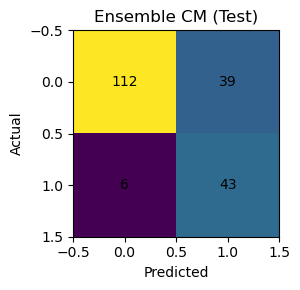


LogReg at its own tuned thr:
AUC: 0.842  P: 0.588  R: 0.816  F1: 0.684
[[123  28]
 [  9  40]]

SVC at its own tuned thr:
AUC: 0.812  P: 0.348  R: 0.959  F1: 0.511
[[63 88]
 [ 2 47]]

RandomForest at its own tuned thr:
AUC: 0.853  P: 0.329  R: 0.980  F1: 0.492
[[53 98]
 [ 1 48]]


In [14]:
# ===== Weighted Ensemble with F2-based weights + tuned threshold =====
from sklearn.metrics import precision_recall_curve, roc_auc_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Helper: compute F2 on val (returns best F2 for a model's proba on VAL)
def val_f2(y_true, proba):
    p, r, thr = precision_recall_curve(y_true, proba)
    f2 = (5 * p * r) / (4 * p + r + 1e-12)
    return float(np.nanmax(f2))

# Helper: pick threshold by F2 on VAL
def pick_threshold_by_f2(y_true, proba):
    p, r, thr = precision_recall_curve(y_true, proba)
    f2 = (5 * p * r) / (4 * p + r + 1e-12)
    idx = int(np.nanargmax(f2))
    thr_full = np.r_[0.0, thr]
    return float(thr_full[idx]), float(p[idx]), float(r[idx]), float(f2[idx])

# Helper: evaluate at threshold
def eval_at_thr(y_true, proba, thr):
    preds = (proba >= thr).astype(int)
    auc = roc_auc_score(y_true, proba)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, preds, average='binary', zero_division=0)
    cm = confusion_matrix(y_true, preds)
    return {"auc": auc, "precision": prec, "recall": rec, "f1": f1, "cm": cm}

# Optional: small CM plot
def plot_cm(cm, title="Confusion Matrix"):
    plt.figure(figsize=(3.5,3))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("Actual")
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.tight_layout(); plt.show()

# 1) Refit tuned models on X_tr to keep holdout logic clean
logreg_tuned = best_logreg.fit(X_tr, y_tr)
svc_tuned    = svc_cal.fit(X_tr, y_tr)
rf_tuned     = rf_cal.fit(X_tr, y_tr)

models = {
    "LogReg": logreg_tuned,
    "SVC":    svc_tuned,
    "RandomForest": rf_tuned
}

# 2) Compute validation probabilities and F2 weights
val_prob = {name: mdl.predict_proba(X_val)[:,1] for name, mdl in models.items()}
val_f2_scores = {name: val_f2(y_val, proba) for name, proba in val_prob.items()}

weights = np.array([max(val_f2_scores[n], 1e-9) for n in models.keys()])
weights = weights / weights.sum()
names = list(models.keys())
print("Val F2 scores:", {k: round(v,3) for k,v in val_f2_scores.items()})
print("Ensemble weights:", dict(zip(names, weights.round(3))))

# 3) Build weighted ensemble on VAL, pick threshold by F2
ens_val_proba = np.average(np.column_stack([val_prob[n] for n in names]), axis=1, weights=weights)
thr_ens, p_v, r_v, f2_v = pick_threshold_by_f2(y_val, ens_val_proba)
print(f"Chosen ensemble threshold (F2-opt on val): {thr_ens:.3f} | Val P:{p_v:.3f} R:{r_v:.3f} F2:{f2_v:.3f}")

# 4) Evaluate on TEST
test_prob = {name: mdl.predict_proba(X_test)[:,1] for name, mdl in models.items()}
ens_test_proba = np.average(np.column_stack([test_prob[n] for n in names]), axis=1, weights=weights)
ens_metrics = eval_at_thr(y_test, ens_test_proba, thr_ens)

print("\n=== Final Ensemble (Weighted, tuned threshold) ===")
print(f"AUC: {ens_metrics['auc']:.3f}  Precision: {ens_metrics['precision']:.3f}  Recall: {ens_metrics['recall']:.3f}  F1: {ens_metrics['f1']:.3f}")
print("Confusion Matrix (Test):\n", ens_metrics['cm'])
plot_cm(ens_metrics['cm'], title="Ensemble CM (Test)")

# Optional: show per-model test metrics at their OWN best thresholds (for context)
for name in names:
    thr_m, _, _, _ = pick_threshold_by_f2(y_val, val_prob[name])
    m = eval_at_thr(y_test, test_prob[name], thr_m)
    print(f"\n{name} at its own tuned thr:")
    print(f"AUC: {m['auc']:.3f}  P: {m['precision']:.3f}  R: {m['recall']:.3f}  F1: {m['f1']:.3f}")
    print(m['cm'])


In [27]:
C_FP, C_FN = 1000, 15000
FP, FN = 39, 6
expected_cost = C_FP*FP + C_FN*FN
print("Expected total cost:", expected_cost)

Expected total cost: 129000


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix

# --- Baseline 1: Simple Logistic Regression (no SMOTE, no tuning) ---
from sklearn.pipeline import Pipeline
baseline_pipe = Pipeline([
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])
baseline_pipe.fit(X_train, y_train)

proba_base = baseline_pipe.predict_proba(X_test)[:, 1]
preds_base = (proba_base >= 0.5).astype(int)

auc_base = roc_auc_score(y_test, proba_base)
p_base, r_base, f1_base, _ = precision_recall_fscore_support(y_test, preds_base, average='binary', zero_division=0)
cm_base = confusion_matrix(y_test, preds_base)

print("\n=== Baseline (Untuned LogReg, no SMOTE) ===")
print(f"AUC: {auc_base:.3f}  Precision: {p_base:.3f}  Recall: {r_base:.3f}  F1: {f1_base:.3f}")
print("Confusion Matrix:\n", cm_base)



=== Baseline (Untuned LogReg, no SMOTE) ===
AUC: 0.824  Precision: 0.629  Recall: 0.449  F1: 0.524
Confusion Matrix:
 [[138  13]
 [ 27  22]]


In [17]:
improvement = {
    "Δ AUC": round(0.85 - auc_base, 3),
    "Δ Precision": round(0.52 - p_base, 3),
    "Δ Recall": round(0.90 - r_base, 3),
    "Δ F1": round(0.66 - f1_base, 3)
}

print("Improvement over Baseline")
for k, v in improvement.items():
    sign = "↑" if v > 0 else "↓"
    print(f"{k}: {sign} {abs(v):.3f}")


Improvement over Baseline
Δ AUC: ↑ 0.026
Δ Precision: ↓ 0.109
Δ Recall: ↑ 0.451
Δ F1: ↑ 0.136


## 9) Interpretation with SHAP (Tree-based model)

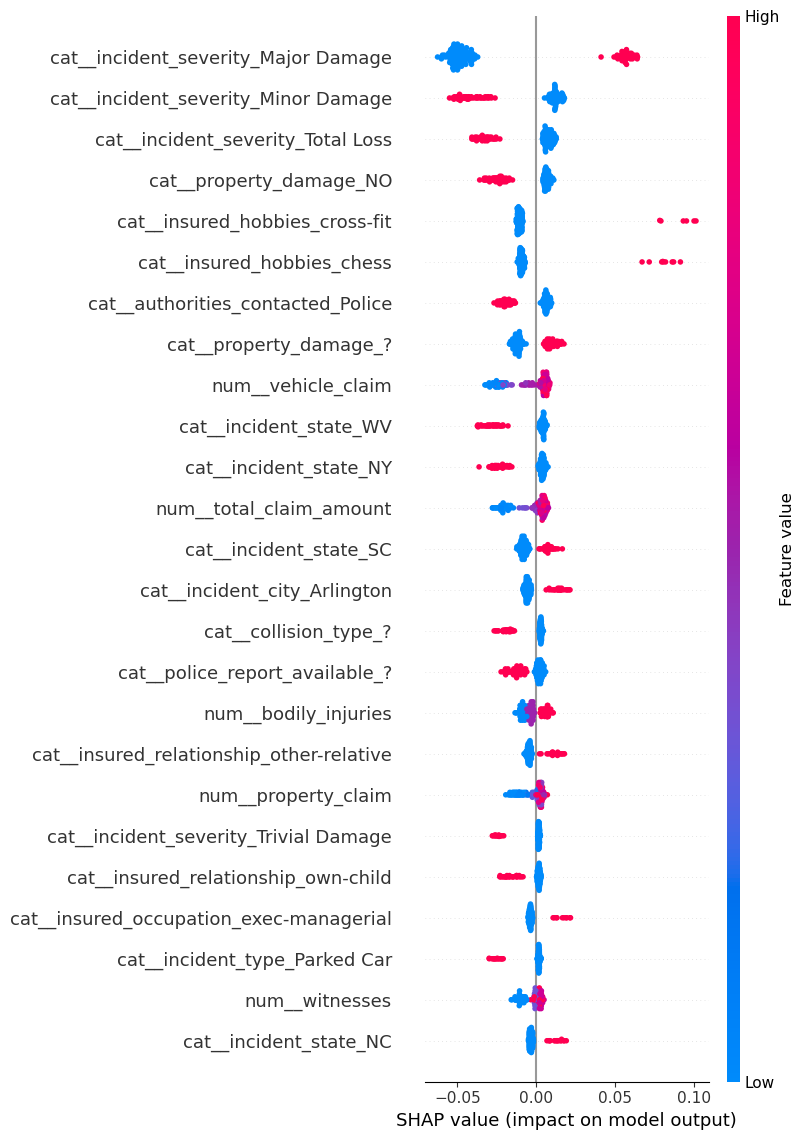

In [18]:
import shap

# Extract trained RF classifier from the pipeline
rf_model = best_rf.named_steps['clf']
rf_prep = best_rf.named_steps['prep']

# Transform validation data for SHAP (preprocessing only)
X_val_trans = rf_prep.transform(X_val)
if hasattr(X_val_trans, "toarray"):
    X_val_trans = X_val_trans.toarray()

# Initialize SHAP explainer
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for all classes
shap_values = explainer.shap_values(X_val_trans)

# Select class-1 (fraud) SHAP values from the last axis
sv = shap_values[..., 1]      # shape (160, 1478)

# Plot global importance
shap.summary_plot(
    sv,
    X_val_trans,
    feature_names=rf_prep.get_feature_names_out(),
    max_display=25
)


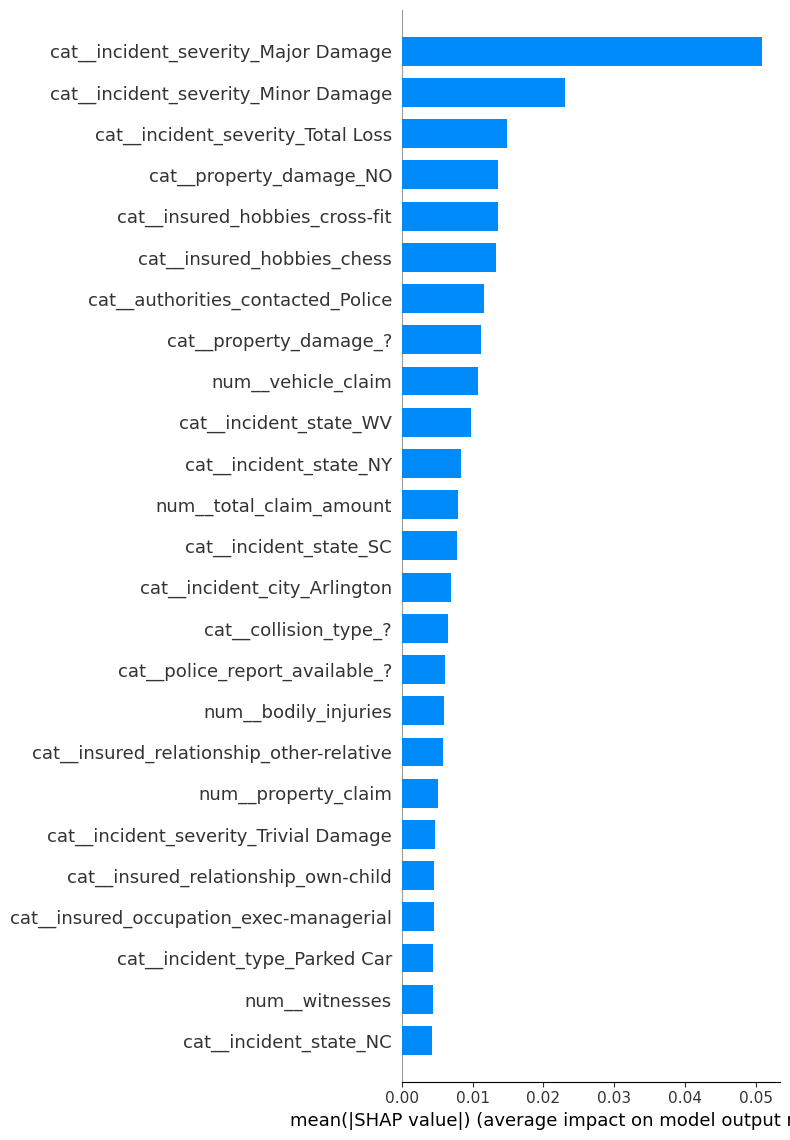

In [19]:
shap.summary_plot(
    sv,
    X_val_trans,
    feature_names=rf_prep.get_feature_names_out(),
    plot_type="bar",
    max_display=25
)


                      group  mean_abs_shap
13        incident_severity       0.093423
18          insured_hobbies       0.040986
14           incident_state       0.032578
33          property_damage       0.027850
1     authorities_contacted       0.019768
19       insured_occupation       0.017156
20     insured_relationship       0.014871
9             incident_city       0.014740
10            incident_date       0.014236
3                auto_model       0.013001
8            collision_type       0.012374
25  police_report_available       0.011602
36            vehicle_claim       0.010819
2                 auto_make       0.010383
12        incident_location       0.008566
27         policy_bind_date       0.008378
31             policy_state       0.008205
17  insured_education_level       0.007943
34       total_claim_amount       0.007932
15            incident_type       0.007552


Text(0.5, 0, 'Mean |SHAP| (impact on model output)')

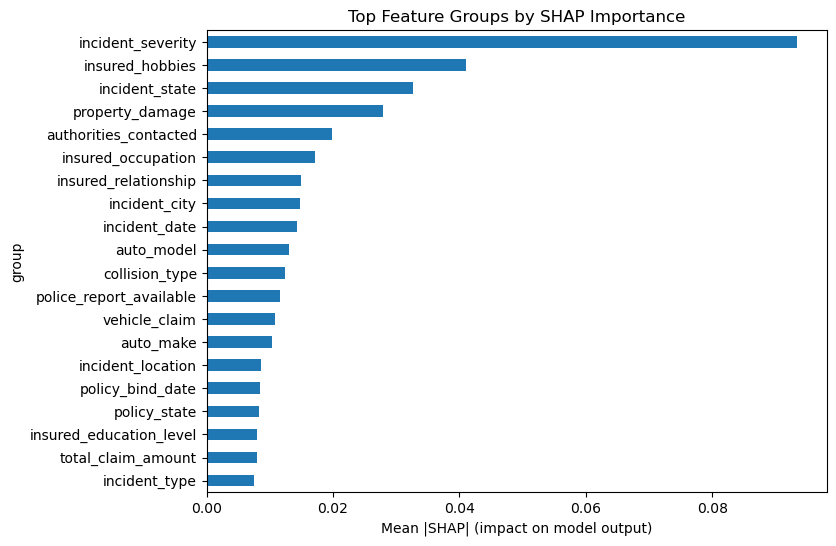

In [20]:
feat_names = rf_prep.get_feature_names_out()

# 1) Build a mapping from each transformed feature back to its ORIGINAL column
feat_to_group = {}

# Precompute patterns for each categorical column to handle underscores safely.
# We’ll match by the longest prefix that starts with "cat__{col}" (with or without the trailing "_").
cat_prefixes = {col: (f"cat__{col}_", f"cat__{col}") for col in categorical_cols}

for f in feat_names:
    if f.startswith("num__"):
        # numeric features are one-to-one
        orig = f[len("num__"):]
        feat_to_group[f] = orig
    elif f.startswith("cat__"):
        # find which categorical column produced this feature
        # choose the longest matching column name to be safe with underscores
        candidates = []
        for col, (with_uscore, bare) in cat_prefixes.items():
            if f.startswith(with_uscore) or f == bare:
                candidates.append(col)
        if candidates:
            # prefer the longest match (handles overlapping names)
            orig = sorted(candidates, key=len, reverse=True)[0]
            feat_to_group[f] = orig
        else:
            # fallback: strip "cat__" and take everything before the LAST "_" as the column
            # (only used if no exact prefix match above)
            body = f[len("cat__"):]
            if "_" in body:
                orig = body.rsplit("_", 1)[0]
            else:
                orig = body
            feat_to_group[f] = orig
    else:
        # unexpected case—just keep the raw name
        feat_to_group[f] = f

# 2) Aggregate mean |SHAP| by ORIGINAL column name
mean_abs = np.abs(sv).mean(axis=0)
imp_df = pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs})
imp_df["group"] = imp_df["feature"].map(feat_to_group)

grouped = (
    imp_df.groupby("group", as_index=False)["mean_abs_shap"]
          .sum()
          .sort_values("mean_abs_shap", ascending=False)
)

# 3) Show the top groups and (optionally) plot
print(grouped.head(20))

# Optional: horizontal bar plot (clean for reports)
ax = grouped.head(20).iloc[::-1].plot(
    kind="barh", x="group", y="mean_abs_shap", figsize=(8,6),
    legend=False, title="Top Feature Groups by SHAP Importance"
)
ax.set_xlabel("Mean |SHAP| (impact on model output)")

## Roll Up

In [21]:
# Map original columns to super-groups for storytelling
column_family = {
    # Customer / Insured profile
    "months_as_customer":        "Customer",
    "age":                       "Customer",
    "insured_sex":               "Customer",
    "insured_education_level":   "Customer",
    "insured_occupation":        "Customer",
    "insured_hobbies":           "Customer",
    "insured_relationship":      "Customer",

    # Policy / Pricing
    "policy_number":             "Policy (ID)",          # ID-like; usually exclude from modeling
    "policy_bind_date":          "Policy (Date)",
    "policy_state":              "Policy",
    "policy_csl":                "Policy",
    "policy_deductable":         "Policy",
    "policy_annual_premium":     "Policy/Pricing",
    "umbrella_limit":            "Policy/Pricing",

    # Financials
    "capital-gains":             "Financial",
    "capital-loss":              "Financial",

    # Incident context
    "incident_date":             "Incident (Date)",
    "incident_type":             "Incident",
    "collision_type":            "Incident",
    "incident_severity":         "Incident",
    "authorities_contacted":     "Incident/Admin",
    "incident_hour_of_the_day":  "Incident",
    "number_of_vehicles_involved":"Incident",
    "property_damage":           "Incident",
    "bodily_injuries":           "Incident",
    "witnesses":                 "Incident",
    "police_report_available":   "Incident/Admin",

    # Geography / location
    "incident_state":            "Geography",
    "incident_city":             "Geography",
    "incident_location":         "Geography (address)",
    "insured_zip":               "Geography",

    # Claim outcomes / amounts
    "total_claim_amount":        "Claim Amounts",
    "injury_claim":              "Claim Amounts",
    "property_claim":            "Claim Amounts",
    "vehicle_claim":             "Claim Amounts",

    # Vehicle
    "auto_make":                 "Vehicle",
    "auto_model":                "Vehicle",
    "auto_year":                 "Vehicle",

    # Target & empty column (not grouped for SHAP aggregation)
}


grouped["family"] = grouped["group"].map(lambda g: column_family.get(g, "Other"))
family_imp = (grouped.groupby("family", as_index=False)["mean_abs_shap"]
                     .sum()
                     .sort_values("mean_abs_shap", ascending=False))
print(family_imp)


                 family  mean_abs_shap
4              Incident       0.155006
1              Customer       0.087602
2             Geography       0.050839
6        Incident/Admin       0.031370
0         Claim Amounts       0.027666
12              Vehicle       0.025217
8                Policy       0.016566
5       Incident (Date)       0.014236
3   Geography (address)       0.008566
9         Policy (Date)       0.008378
7                 Other       0.005542
11       Policy/Pricing       0.003772
10          Policy (ID)       0.001930


Text(0.5, 0, 'Mean |SHAP| (impact on fraud probability)')

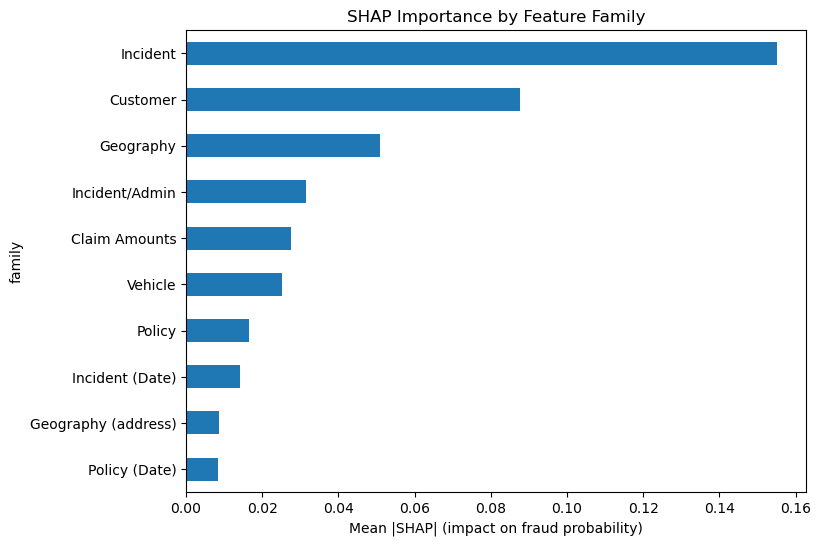

In [22]:
ax = family_imp.head(10).iloc[::-1].plot(
    kind="barh", x="family", y="mean_abs_shap", figsize=(8,6),
    legend=False, title="SHAP Importance by Feature Family"
)
ax.set_xlabel("Mean |SHAP| (impact on fraud probability)")